In [1]:
import sys
sys.path.append('../')
from QC import *
sc.settings.set_figure_params(dpi=80)

In [2]:
#human data cross test
test = sc.read_h5ad('../data/3907_AS2.h5ad')
test2 = sc.read_h5ad('../data/3907_AS1.h5ad')

In [3]:
positive = sc.read_h5ad('../data/3907_AS2_MitoFilter_Bob.h5ad')
positive2 = sc.read_h5ad('../data/3907_AS1_MitoFilter_Bob.h5ad')

In [4]:
%%time
# quick reordering of AnnData object, since our inflection point analysis assumes that libraries are sorted from highest to lowest quality
reorder_adata(test)
reorder_adata(test2)
# create new "observations" as percent and mean mito genes
test2.var['mito'] = test2.var_names.str.contains('MT-') # identify mitochondrial genes
test2.obs['mean_mito'] = np.mean(test2[:,test2.var['mito']].X, axis=1) # add average mitochondrial expression to .obs
sc.pp.calculate_qc_metrics(test2, qc_vars=['mito'], inplace=True) # calculate standard qc .obs and .var
# create new "observations" as percent and mean mito genes
test.var['mito'] = test.var_names.str.contains('MT-') # identify mitochondrial genes
test.obs['mean_mito'] = np.mean(test[:,test.var['mito']].X, axis=1) # add average mitochondrial expression to .obs
sc.pp.calculate_qc_metrics(test, qc_vars=['mito'], inplace=True) # calculate standard qc .obs and .var
# rank cells by total counts and save as .obs
test2.obs['ranked_total_counts'] = np.argsort(test2.obs['total_counts'])
test.obs['ranked_total_counts'] = np.argsort(test.obs['total_counts'])

Wall time: 37.5 s


In [5]:
#For Bob's Filter
f1 = np.isin(test.obs.index, positive.obs.index)
test.obs['bob_filter']=0
test.obs.loc[f1, 'bob_filter'] = 1
        
f2 = np.isin(test2.obs.index, positive2.obs.index)
test2.obs['bob_filter']=0
test2.obs.loc[f2, 'bob_filter'] = 1

In [6]:
#Common gene index search
common = np.isin(test.var.index, test2.var.index)
#Common gene list + new anndata
common_gene= []
for i in range(0,len(common)):
    if common[i]:
        common_gene.append(test.var.index[i])

In [7]:
#new anndata
test_common_genes = test[:, common_gene]
test2_common_genes = test2[:, common_gene]

In [8]:
test_common_genes.obs['set'] = 'train'
test2_common_genes.obs['set'] = 'test'

Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.


In [9]:
merge_data = test_common_genes.concatenate(test2_common_genes)

In [10]:
%%time
sc.pp.normalize_total(merge_data, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(merge_data) # log1p transformation
sc.pp.scale(merge_data, max_value=10) # scaling by variance and centering to zero for visualization

Wall time: 1min 15s


In [11]:
len(test2_common_genes.var)

27464

In [12]:
%%time
sc.pp.normalize_total(test2_common_genes, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(test2_common_genes) # log1p transformation
sc.pp.scale(test2_common_genes, max_value=10) # scaling by variance and centering to zero for visualization

Wall time: 38.9 s


... storing 'set' as categorical


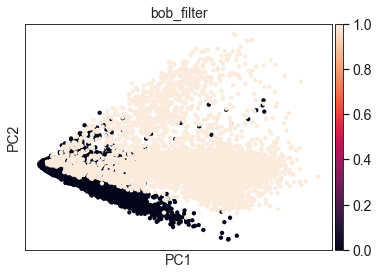

... storing 'set' as categorical


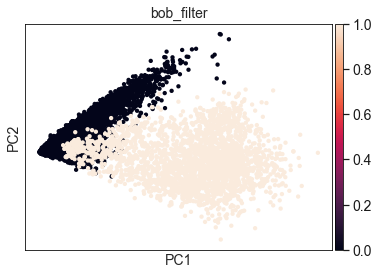

In [13]:
sc.tl.pca(merge_data, n_comps=100) # perform PCA and plot results
sc.pl.pca(merge_data, color=['bob_filter'], ncols=4, size=75)
sc.tl.pca(test2_common_genes, n_comps=10) # perform PCA and plot results
sc.pl.pca(test2_common_genes, color=['bob_filter'], ncols=4, size=75)

In [14]:
array1 = np.where(merge_data.obs['set']== 'train')
array2 = np.where(merge_data.obs['set']== 'test')
X=merge_data.obsm['X_pca'] 
y=merge_data.obs['bob_filter']

rf = RandomForestClassifier(n_estimators=1000, max_depth=10,random_state=2)
lr = LogisticRegressionCV(cv=5, random_state=2, multi_class='multinomial', max_iter=1000)

lr.fit(X[array1[0]], y[array1[0]])
prediction = lr.predict(X[array2[0]])
test2_common_genes.obs['binary']=prediction


In [15]:
f_positive = 0
f_negative = 0
for i in range(0,len(test2)):
    if test2_common_genes.obs['binary'][i]-test2.obs['bob_filter'][i]>0:
        f_positive +=1
    if test2_common_genes.obs['binary'][i]-test2.obs['bob_filter'][i]<0:
        f_negative +=1
total_acc = 1-((f_negative)/sum(test2.obs['bob_filter']))
print('miss-labeled as cell:',f_positive,'; mislabeled as empty:',f_negative,'; correct N-label percent is %0.2f)' % total_acc)

miss-labeled as cell: 30 ; mislabeled as empty: 306 ; correct N-label percent is 0.87)


In [24]:
test2_common_genes.obsm['X_pca']

array([[ 1.12139122e+02, -3.26577115e+00, -1.11462278e+01, ...,
        -1.34451985e-01,  5.74137068e+00, -1.03866844e+01],
       [ 1.24514946e+02, -4.13613081e+00, -2.94581261e+01, ...,
        -5.26889205e-01,  5.98659420e+00, -1.03756981e+01],
       [ 1.14876152e+02, -7.15451622e+00, -1.06188116e+01, ...,
        -3.50199699e-01,  9.16258633e-01, -8.13438702e+00],
       ...,
       [-1.01964903e+01, -3.90414500e+00, -1.82682228e+00, ...,
         7.64167786e+00, -7.12961555e-01,  1.05699348e+00],
       [-9.77116299e+00, -9.12138104e-01, -1.00640368e+00, ...,
         1.00686665e+01,  2.89641507e-02, -3.98431033e-01],
       [-1.02111874e+01, -2.71120334e+00, -1.64077270e+00, ...,
         7.87722683e+00,  6.31008327e-01,  1.10419042e-01]], dtype=float32)

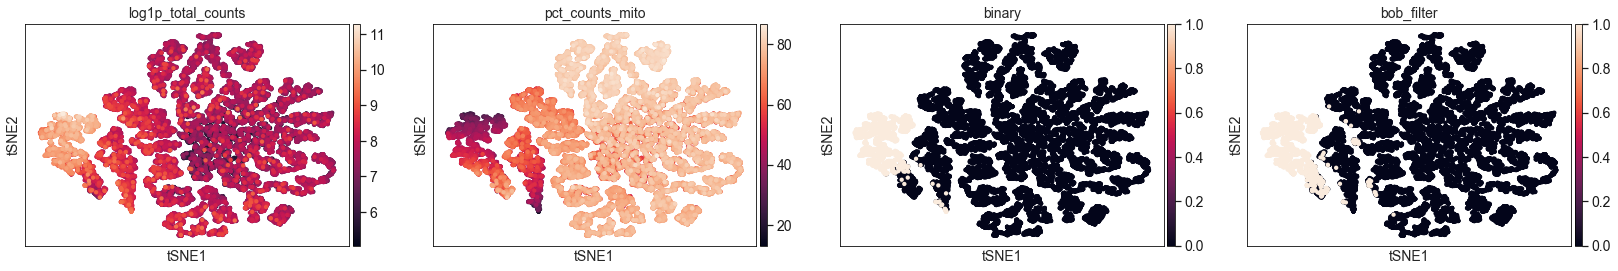

In [23]:

#sc.tl.tsne(test2_common_genes, n_pcs=2,n_jobs=-1) # perform tsne and plot results
sc.pl.tsne(test2_common_genes, color=['log1p_total_counts','pct_counts_mito','binary','bob_filter'], ncols=4, size=75)